<a href="https://colab.research.google.com/github/christianasb/Bitcoin-Mining-Dispatch-Model/blob/main/bitcoin_mining_dispatch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bitcoin Mining Dispatch Model (ERCOT)

This notebook builds and evaluates a Bitcoin mining dispatch model using ERCOT 15‑minute prices and the Hashrate Index **hashprice** data.  
I am keeping language simple, using clear steps, and printing short interpretations after each section.

**Goal:**  
- assessing profitability based on miner efficiency and hashprice  
- identifying when to operate or shut down (dispatch)  
- computing overall profitability for a backtest window  
- presenting high-level insights and simple visualizations

## Outline
1. User Inputs  
2. Setup & Libraries  
3. Data Ingestion (ERCOT CSVs and Hashrate Index API)  
4. Preprocessing & Merge (aligning 15‑minute intervals)  
5. Profitability Assessment (from efficiency)  
6. Dispatch Logic (on/off)  
7. Backtest Results (revenue, cost, profit, uptime, energy)  
8. High-Level Insights (hourly run rate, top/bottom days, contiguous runs)  
9. Visualizations (cumulative profit, hourly run rate, margin distribution)  
10. Conclusions

## 1) User Inputs

Define all inputs here. Only edit this cell, everything after "="
- **Facility and miner settings**
- **Date range**
- **Zone settings**
- **Cost settings** (spot price vs. PPA)
- **Hashrate Index API key** (needed for hashprice)

In [17]:
# Facility and miner settings
facility_size       = 50.0   # Mining facility size in MW
machine_efficiency  = 22.0   # Miner efficiency in Watts per Terahash (W/TH)

# Date range for backtest
# Format: YYYY-MM-DD (I am including the full end day up to 23:45 UTC)
date_start = "2022-01-01"
date_end   = "2024-12-31"

# Load zone (LZ) & price type settings
# LZ_selection can be "ALL" or a single zone like "LZ_HOUSTON" or a list like ["LZ_HOUSTON","LZ_NORTH"]
LZ_selection = "ALL"

# Name of the price column in your ERCOT CSVs ('lmp_with_adders' or 'lmp').
ercot_price = "lmp_with_adders"

# Cost settings
use_fixed_PPA   = False               # False = use ERCOT spot price; True = use fixed PPA
PPA_price_MWh   = 50.0                # $/MWh (only used if use_fixed_PPA = True)
variable_OM_MWh = 0.0                 # $/MWh variable O&M cost

# Hashrate Index API Key
# Replace with your key from hashrateindex.com
API_KEY = "hi.7dfcbe36e3eb05b795fc44279cd3cc"

## 2) Setup & Libraries

I am importing needed libraries and creating a simple folder for ERCOT CSVs.  
In Colab, I upload ERCOT CSVs into `/content/ercot_csv`.

In [18]:
import glob
from pathlib import Path

import numpy as np
import pandas as pd
import requests as rq
import matplotlib.pyplot as plt
import gdown as gd

# Create data folder (upload your ERCOT CSVs here in Colab)
ercot_folder = "/content/ercot_csv"
Path(ercot_folder).mkdir(parents=True, exist_ok=True)

print("ERCOT folder:", ercot_folder)

ERCOT folder: /content/ercot_csv


## 3) Data Ingestion

### 3.1 ERCOT CSVs (15‑minute prices)
I am loading all CSVs under `/content/ercot_csv`.  
Since headers can vary across files, I am normalizing column names and resolving the correct timestamp, location, and price columns.

**Instructions:** Upload your ERCOT 15‑minute price CSVs to `/content/ercot_csv`.

In [19]:
# Data from Google Drive folder
ercot_pricing_data = "https://drive.google.com/drive/folders/16_h2zCMZZywytt0IV4RneUsiETwMtQwx?usp=sharing"

# Defining local folder where ERCOT CSVs will be saved
ercot_folder = "/content/ercot_csv"
Path(ercot_folder).mkdir(parents=True, exist_ok=True)

# Downloading all CSVs from Google Drive folder into local folder
gd.download_folder(url=ercot_pricing_data, output=ercot_folder, quiet=True, use_cookies=False)

# Load & combine ERCOT CSVs
ercot_csvs = []
for fp in glob.glob(f"{ercot_folder}/**/*.csv", recursive=True):
    try:
        tmp = pd.read_csv(fp)
        ercot_csvs.append(tmp)
    except Exception as e:
        print(f"Skipping {fp} due to read error: {e}")

if not ercot_csvs:
    raise RuntimeError("No ERCOT CSVs found in /content/ercot_csv. Please upload your files and re-run.")

ercot_df = pd.concat(ercot_csvs, ignore_index=True)

# Normalize column names (lowercase, underscores)
ercot_df.columns = [c.strip().lower().replace(" ", "_") for c in ercot_df.columns]
print("Sample ERCOT columns:", list(ercot_df.columns)[:20])

# Helper to pick a column by preferred names or fuzzy tokens
def pick_col(df, preferred, aliases=(), fuzzy=None, must=True):
    cols = set(df.columns)
    # exact matches
    for name in [preferred, *aliases]:
        if name in cols:
            return name
    # fuzzy (all tokens must appear)
    if fuzzy:
        for c in df.columns:
            if all(tok in c for tok in fuzzy):
                return c
    if must:
        raise KeyError(f"Could not find any of: {preferred} / {aliases} (fuzzy={fuzzy}) in columns.")
    return None

# Resolve key columns
ts_col = pick_col(
    ercot_df,
    preferred="interval_start_utc",
    aliases=("start_time_utc","interval_start","timestamp_utc","timestamp","delivery_start_utc"),
    fuzzy=("start","utc")
)
loc_col = pick_col(
    ercot_df,
    preferred="location",
    aliases=("load_zone","settlement_point","zone","lz"),
    fuzzy=("l","z")  # loose fallback
)

desired_price_norm = ercot_price.strip().lower().replace(" ", "_")
price_col = pick_col(
    ercot_df,
    preferred=desired_price_norm,
    aliases=("rtm_lmp_with_adders","lmp_with_adders","rtm_lmp","lmp","settlement_point_price","price"),
    fuzzy=("lmp",)  # fallback to any column containing 'lmp'
)

# Build a clean ERCOT zone dataframe
ercot_zone = (
    ercot_df[[ts_col, loc_col, price_col]]
        .rename(columns={ts_col:"interval_start_utc", loc_col:"location", price_col:"lz_price"})
        .copy()
)

# Parse timestamps to UTC 15-min grid and clean price
ercot_zone["interval_start_utc"] = pd.to_datetime(ercot_zone["interval_start_utc"], utc=True, errors="coerce").dt.floor("15min")
ercot_zone["lz_price"] = pd.to_numeric(ercot_zone["lz_price"], errors="coerce")

# Drop bad rows and duplicates
ercot_zone = (
    ercot_zone.dropna(subset=["interval_start_utc","location","lz_price"])
              .drop_duplicates(subset=["interval_start_utc","location"])
              .sort_values(["location","interval_start_utc"])
              .reset_index(drop=True)
)

print("ERCOT rows:", len(ercot_zone))
print("ERCOT zones sample:", sorted(ercot_zone['location'].unique())[:10])

Sample ERCOT columns: ['interval_start_local', 'interval_start_utc', 'interval_end_local', 'interval_end_utc', 'location', 'lmp', 'rtorpa', 'rtordpa', 'lmp_with_adders']
ERCOT rows: 507370
ERCOT zones sample: ['LZ_HOUSTON', 'LZ_NORTH', 'LZ_SOUTH', 'LZ_WEST']


### 3.2 Hashrate Index: hashprice
I am pulling hashprice via API, sampling at 6 hours, then forward‑filling to 15‑minute intervals to match ERCOT.

In [20]:
# Date window (inclusive through 23:45 on end date)
start_dt_utc = pd.to_datetime(date_start, utc=True)
end_dt_utc   = pd.to_datetime(date_end + " 23:45", utc=True)

hashprice_url     = "https://api.hashrateindex.com/v1/hashrateindex/hashprice"
hashprice_headers = {"X-Hi-Api-Key": API_KEY}
hashprice_params  = {"span": "5Y", "bucket": "6H", "currency": "USD", "hashunit": "THS"}

# Request (will run in Colab; internet disabled in some environments)
resp = rq.get(hashprice_url, headers=hashprice_headers, params=hashprice_params, timeout=60)
resp.raise_for_status()
hp_json = resp.json()

hashprice_df = pd.DataFrame(hp_json.get("data", []))
if hashprice_df.empty:
    raise RuntimeError("Hashprice API returned no data. Check API key or try again.")

hashprice_df["interval_start_utc"] = pd.to_datetime(hashprice_df["timestamp"], utc=True, errors="coerce").dt.floor("15min")
hashprice_df = (
    hashprice_df.rename(columns={"price":"hashprice_usd_th_day"})
                .drop(columns=["timestamp"], errors="ignore")
                .dropna(subset=["interval_start_utc","hashprice_usd_th_day"])
                .drop_duplicates(subset=["interval_start_utc"])
                .sort_values("interval_start_utc")
                .reset_index(drop=True)
)

# Resample 6H -> 15min and clip to window
hashprice_df = (hashprice_df.set_index("interval_start_utc").resample("15min").ffill().reset_index())
hashprice_df = hashprice_df[
    (hashprice_df["interval_start_utc"] >= start_dt_utc) &
    (hashprice_df["interval_start_utc"] <= end_dt_utc)
].reset_index(drop=True)

print("Hashprice rows in window:", len(hashprice_df))

Hashprice rows in window: 105216


## 4) Preprocessing & Merge

I am filtering ERCOT to the date window and selected zones, then merging on the 15‑minute timestamp.  
Hashprice is a network‑wide revenue metric, so it does not change by zone at a given timestamp.

In [21]:
# Filter ERCOT to date window
ercot_zone = ercot_zone[
    (ercot_zone["interval_start_utc"] >= start_dt_utc) &
    (ercot_zone["interval_start_utc"] <= end_dt_utc)
]

# Apply LZ selection
if isinstance(LZ_selection, str) and LZ_selection.upper() != "ALL":
    ercot_zone = ercot_zone[ercot_zone["location"] == LZ_selection]
elif isinstance(LZ_selection, (list, tuple, set)):
    ercot_zone = ercot_zone[ercot_zone["location"].isin(LZ_selection)]

if ercot_zone.empty:
    raise RuntimeError("ERCOT data empty after filters. Check LZ_selection, dates, or data columns.")

# Merge
merged = (
    pd.merge(
        ercot_zone[["interval_start_utc","location","lz_price"]],
        hashprice_df[["interval_start_utc","hashprice_usd_th_day"]],
        on="interval_start_utc",
        how="inner"
    )
    .sort_values(["location","interval_start_utc"])
    .reset_index(drop=True)
)

print("Merged rows:", len(merged))
print("Locations in merged:", sorted(merged['location'].unique())[:10])

Merged rows: 420576
Locations in merged: ['LZ_HOUSTON', 'LZ_NORTH', 'LZ_SOUTH', 'LZ_WEST']


## 5) Profitability Assessment (from efficiency)

I am converting miner efficiency (W/TH) into **TH per MW**, then turning hashprice (USD/TH/day) into **USD/MWh**.  
This gives revenue per unit of energy. Electricity price drives **cost per MWh**.  
I am printing averages and a short interpretation.

In [22]:
# Efficiency: W/TH -> TH per MW (1 MW = 1,000,000 W)
terahash_per_mw = 1_000_000.0 / float(machine_efficiency)

# Revenue per MWh from hashprice & efficiency
merged["revenue_per_mwh"] = (merged["hashprice_usd_th_day"] / 24.0) * terahash_per_mw

# Cost per MWh: PPA or spot ERCOT price + variable O&M
if use_fixed_PPA:
    merged["cost_per_mwh"] = float(PPA_price_MWh) + float(variable_OM_MWh)
else:
    merged["cost_per_mwh"] = merged["lz_price"] + float(variable_OM_MWh)

merged["gross_margin_per_mwh"] = merged["revenue_per_mwh"] - merged["cost_per_mwh"]

print("=== Profitability Assessment ===")
avg_rev = merged["revenue_per_mwh"].mean()
avg_cost = merged["cost_per_mwh"].mean()
avg_margin = merged["gross_margin_per_mwh"].mean()
print(f"Average revenue per MWh: ${avg_rev:,.2f}")
print(f"Average cost per MWh:    ${avg_cost:,.2f}")
print(f"Average margin per MWh:  ${avg_margin:,.2f}")

=== Profitability Assessment ===
Average revenue per MWh: $166.09
Average cost per MWh:    $48.43
Average margin per MWh:  $117.66


Interpretation:
- Revenue per MWh is coming from network economics (hashprice) and miner efficiency.
- Costs per MWh come from the power price (or PPA).
- Positive average margin suggests the mine is generally profitable per unit of energy.

## 6) Dispatch Logic (on/off)

I am mining when **gross margin per MWh > 0**.  
I am calculating energy, revenue, cost, and P&L per interval for a facility size in MW.

In [23]:
# On/off rule
merged["dispatch_on"] = merged["gross_margin_per_mwh"] > 0

# 15-min energy for the facility when ON
MWH_PER_INTERVAL = facility_size * 0.25  # 15 min = 0.25 hour

merged["energy_mwh"]  = np.where(merged["dispatch_on"], MWH_PER_INTERVAL, 0.0)
merged["revenue_usd"] = merged["revenue_per_mwh"] * merged["energy_mwh"]
merged["cost_usd"]    = merged["cost_per_mwh"]    * merged["energy_mwh"]
merged["pnl_usd"]     = merged["revenue_usd"] - merged["cost_usd"]

print("=== Dispatch Sample (first 5 rows) ===")
print(merged[["interval_start_utc","location","lz_price","revenue_per_mwh","cost_per_mwh","gross_margin_per_mwh","dispatch_on"]].head())


=== Dispatch Sample (first 5 rows) ===
         interval_start_utc    location    lz_price  revenue_per_mwh  \
0 2022-01-01 06:00:00+00:00  LZ_HOUSTON   51.567933       467.763073   
1 2022-01-01 06:15:00+00:00  LZ_HOUSTON  127.041225       467.763073   
2 2022-01-01 06:30:00+00:00  LZ_HOUSTON   38.916467       467.763073   
3 2022-01-01 06:45:00+00:00  LZ_HOUSTON   34.923467       467.763073   
4 2022-01-01 07:00:00+00:00  LZ_HOUSTON   31.904633       467.763073   

   cost_per_mwh  gross_margin_per_mwh  dispatch_on  
0     51.567933            416.195140         True  
1    127.041225            340.721848         True  
2     38.916467            428.846607         True  
3     34.923467            432.839607         True  
4     31.904633            435.858440         True  


Interpretation:
- A True value means the mine is running for that 15-minute interval.
- Dispatch is sensitive to electricity prices; hashprice is common to all zones at a given time.


## 7) Backtest Results

I am computing total revenue, total cost, total profit, uptime %, and total energy used.  
Then I am summarizing by zone and printing short interpretations.

In [24]:
def summarize_zone(df):
    energy = df["energy_mwh"].sum()
    # Energy-weighted averages during ON time
    if energy > 0:
        w = df["energy_mwh"].values
        avg_paid = (df["cost_per_mwh"].values * w).sum() / energy
        avg_rev  = (df["revenue_per_mwh"].values * w).sum() / energy
    else:
        avg_paid = np.nan
        avg_rev  = np.nan
    return pd.Series({
        "intervals": len(df),
        "uptime_pct": 100.0 * df["dispatch_on"].mean(),
        "energy_used_mwh": energy,
        "total_revenue_usd": df["revenue_usd"].sum(),
        "total_cost_usd": df["cost_usd"].sum(),
        "profit_usd": df["pnl_usd"].sum(),
        "avg_price_paid_per_mwh": avg_paid,
        "avg_revenue_per_mwh": avg_rev,
        "gross_margin_pct": (100.0 * (avg_rev - avg_paid) / avg_rev) if (energy > 0 and pd.notna(avg_rev) and avg_rev != 0) else np.nan
    })

zone_summary = merged.groupby("location", as_index=False).apply(summarize_zone).reset_index(drop=True)

overall = summarize_zone(merged)
overall["window_start"] = merged["interval_start_utc"].min()
overall["window_end"]   = merged["interval_start_utc"].max()

def fmt_money(x):
    return "$" + f"{x:,.0f}"

print("=== OVERALL SUMMARY ===")
print(f"Window (UTC): {overall['window_start']} → {overall['window_end']}")
print(f"Facility: {facility_size:.1f} MW | Efficiency: {machine_efficiency:.2f} W/TH")
print(f"Uptime: {overall['uptime_pct']:.1f}%")
print(f"Energy Used: {overall['energy_used_mwh']:,.0f} MWh")
print(f"Total Revenue: {fmt_money(overall['total_revenue_usd'])}  |  Total Cost: {fmt_money(overall['total_cost_usd'])}  |  Profit: {fmt_money(overall['profit_usd'])}")
gm = overall['gross_margin_pct']
print(f"Gross Margin: {gm:.1f}%") if pd.notna(gm) else print("Gross Margin: NA")

print("\n=== SUMMARY BY ZONE ===")
display_cols = ["location","uptime_pct","energy_used_mwh","total_revenue_usd","total_cost_usd","profit_usd",
                "avg_price_paid_per_mwh","avg_revenue_per_mwh","gross_margin_pct"]
print(zone_summary[display_cols].to_string(index=False,
    formatters={
        "uptime_pct":       lambda v: f"{v:.1f}%",
        "energy_used_mwh":  lambda v: f"{v:,.0f}",
        "total_revenue_usd":fmt_money,
        "total_cost_usd":   fmt_money,
        "profit_usd":       fmt_money,
        "avg_price_paid_per_mwh": lambda v: fmt_money(v)+"/MWh",
        "avg_revenue_per_mwh":    lambda v: fmt_money(v)+"/MWh",
        "gross_margin_pct": lambda v: (f"{v:.1f}%" if pd.notna(v) else "NA")
    }))


=== OVERALL SUMMARY ===
Window (UTC): 2022-01-01 06:00:00+00:00 → 2024-12-31 23:45:00+00:00
Facility: 50.0 MW | Efficiency: 22.00 W/TH
Uptime: 97.3%
Energy Used: 5,113,275 MWh
Total Revenue: $852,834,049  |  Total Cost: $165,789,095  |  Profit: $687,044,954
Gross Margin: 80.6%

=== SUMMARY BY ZONE ===
  location uptime_pct energy_used_mwh total_revenue_usd total_cost_usd   profit_usd avg_price_paid_per_mwh avg_revenue_per_mwh gross_margin_pct
LZ_HOUSTON      97.6%       1,283,012      $213,575,564    $42,101,609 $171,473,955                $33/MWh            $166/MWh            80.3%
  LZ_NORTH      97.8%       1,285,525      $214,216,286    $40,003,344 $174,212,942                $31/MWh            $167/MWh            81.3%
  LZ_SOUTH      97.4%       1,279,712      $213,519,129    $40,393,324 $173,125,805                $32/MWh            $167/MWh            81.1%
   LZ_WEST      96.3%       1,265,025      $211,523,070    $43,290,818 $168,232,252                $34/MWh            $16

/tmp/ipython-input-2999685757.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  zone_summary = merged.groupby("location", as_index=False).apply(summarize_zone).reset_index(drop=True)


Interpretation:
- The overall P&L, uptime, and energy show how the mine performs over the whole period.
- Zone-by-zone differences come from electricity prices; revenue per MWh is the same across zones at a given time.
- A higher uptime with good margins usually leads to better profits.


## 8) High‑Level Insights

I am summarizing hour‑of‑day run rates, best/worst profit days, and contiguous ON/OFF runs.  
I am keeping interpretations simple and concrete.

In [25]:
# Hour-of-day run rate
hod = (merged.assign(hour=merged["interval_start_utc"].dt.hour)
              .groupby(["location","hour"])["dispatch_on"]
              .mean()
              .reset_index(name="run_rate_pct"))
hod["run_rate_pct"] = (hod["run_rate_pct"] * 100).round(1)

print("=== HOUR-OF-DAY RUN RATE (percent of intervals ON) ===")
print(hod.pivot(index="hour", columns="location", values="run_rate_pct").fillna(0).round(1).to_string())

# Best / worst days by P&L
by_day = (merged.assign(date=merged["interval_start_utc"].dt.date)
                 .groupby(["location","date"])["pnl_usd"].sum()
                 .reset_index())
top_days    = by_day.sort_values(["location","pnl_usd"], ascending=[True, False]).groupby("location").head(5)
bottom_days = by_day.sort_values(["location","pnl_usd"], ascending=[True, True ]).groupby("location").head(5)

print("\n=== TOP 5 DAYS BY PROFIT (per zone) ===")
for loc, sub in top_days.groupby("location"):
    print(f"\n{loc}")
    print(sub.sort_values("pnl_usd", ascending=False).to_string(index=False))

print("\n=== BOTTOM 5 DAYS BY PROFIT (per zone) ===")
for loc, sub in bottom_days.groupby("location"):
    print(f"\n{loc}")
    print(sub.sort_values("pnl_usd", ascending=True).to_string(index=False))

# Contiguous ON/OFF blocks
def contiguous_runs(df):
    df = df.sort_values("interval_start_utc").copy()
    df["block"] = (df["dispatch_on"] != df["dispatch_on"].shift()).cumsum()
    out = (df.groupby(["block","dispatch_on"])
             .agg(start=("interval_start_utc","min"),
                  end=("interval_start_utc","max"),
                  intervals=("interval_start_utc","size"))
             .reset_index())
    out["duration_hours"] = out["intervals"] * 0.25
    return out

runs = merged.groupby("location", group_keys=False).apply(contiguous_runs).reset_index()
print("\n=== CONTIGUOUS RUNS (first 15 rows) ===")
print(runs.head(15).to_string(index=False))


=== HOUR-OF-DAY RUN RATE (percent of intervals ON) ===
location  LZ_HOUSTON  LZ_NORTH  LZ_SOUTH  LZ_WEST
hour                                             
0               90.4      89.5      90.4     86.0
1               93.9      93.8      94.1     89.2
2               98.9      98.9      98.5     95.1
3               99.6      99.6      99.3     96.9
4               99.7      99.8      99.6     98.2
5               99.7      99.6      99.7     97.9
6               99.9      99.9      99.9     97.8
7               99.9      99.9      99.9     98.1
8               99.8      99.8      99.7     98.0
9               99.8      99.8      99.8     97.8
10              99.7      99.7      99.5     97.6
11              99.4      99.4      99.3     96.9
12              98.7      98.7      98.6     96.9
13              99.0      98.7      98.7     97.5
14              99.4      99.3      99.3     99.0
15              99.4      99.3      99.5     99.2
16              99.1      99.3      99.5     

/tmp/ipython-input-3159218754.py:40: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  runs = merged.groupby("location", group_keys=False).apply(contiguous_runs).reset_index()


Interpretation:
- Late-night hours usually show higher run rates if power prices are lower.
- Top days often line up with low power prices or high hashprice periods.
- Long contiguous ON blocks are efficient; frequent toggling can be less practical in real operations.


## 9) Visualizations

I am plotting three quick visuals:
1. Cumulative profit over time (to see growth and drawdowns)  
2. Hour‑of‑day run rate (average ON %)  
3. Distribution of gross margin per MWh (how often margins are near/below/above zero)

> Note: I am using Matplotlib only (no seaborn). Each chart is in its own cell.

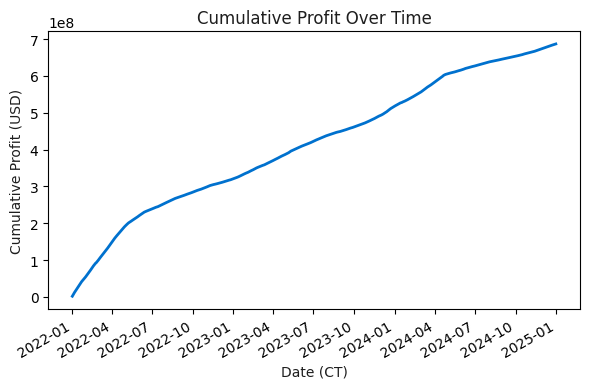

In [32]:
import matplotlib.dates as mdates
import pytz

# Resample to daily cumulative profit
daily = (merged
         .set_index("interval_start_utc")["pnl_usd"]
         .resample("D").sum()
         .cumsum()
         .reset_index())

# Convert to ERCOT Central Time
ct = pytz.timezone("America/Chicago")
daily["interval_start_ct"] = daily["interval_start_utc"].dt.tz_convert(ct)

# Plot
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(daily["interval_start_ct"], daily["pnl_usd"], color="#0071CE", linewidth=2)

# Format x-axis: quarterly ticks, YYYY-MM labels
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))

fig.autofmt_xdate()
ax.set_title("Cumulative Profit Over Time", color="#1E1E1E")
ax.set_xlabel("Date (CT)", color="#1E1E1E")
ax.set_ylabel("Cumulative Profit (USD)", color="#1E1E1E")

plt.tight_layout()
plt.show()

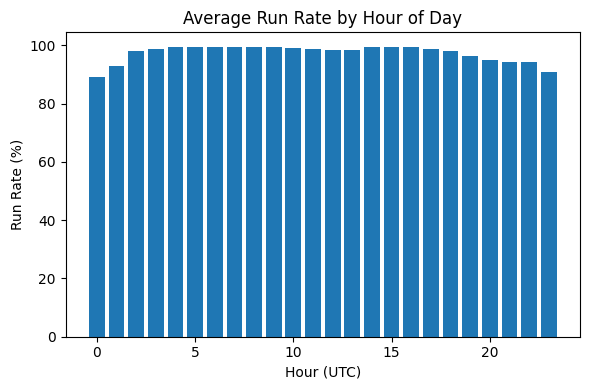

In [33]:
# 2) Hour-of-day run rate (average ON %)
hod_plot = hod.groupby("hour")["run_rate_pct"].mean().reset_index()

plt.figure(figsize=(6,4))
plt.bar(hod_plot["hour"], hod_plot["run_rate_pct"])
plt.title("Average Run Rate by Hour of Day")
plt.xlabel("Hour (UTC)")
plt.ylabel("Run Rate (%)")
plt.tight_layout()
plt.show()

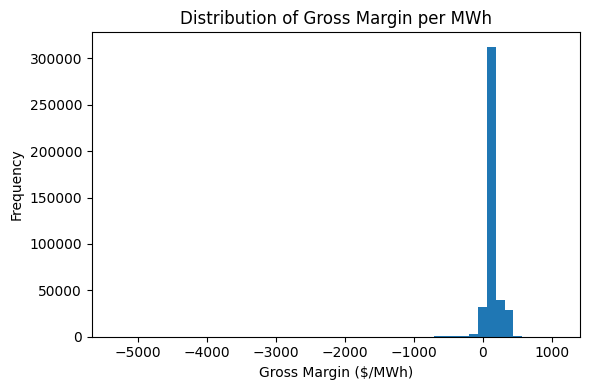

In [36]:
# 3) Gross margin per MWh distribution
plt.figure(figsize=(6,4))
merged["gross_margin_per_mwh"].hist(bins=50)
plt.title("Distribution of Gross Margin per MWh")
plt.xlabel("Gross Margin ($/MWh)")
plt.ylabel("Frequency")
plt.grid(False)
plt.tight_layout()
plt.show()

## 10) Conclusions

**Profitability Assessment:**
- The facility earns **\$166/MWh on average** while paying only **\$48/MWh for power**, leaving a healthy margin of **$118/MWh**.  
- Electricity costs account for **less than one-third** of revenues, which means the operation can absorb moderate price shocks without losing profitability.  
- This margin indicates strong resilience: even if hashprice falls or power prices rise, the facility should remain profitable.  

**Dispatch Decisions:**
- Dispatch is **consistently ON (97% uptime)** because margins are almost always positive.  
- The sample rows show that even when ERCOT prices vary widely, revenue per MWh remains high enough to keep the mine profitable.  
- **Action:** Consider adding a margin buffer (e.g., only mine if margin > $10/MWh) to protect against transaction fees or unmodeled costs.  

**Overall Economics:**
- Over three years, the facility generated **\$852M in revenue** against **\$166M in costs**, with a total profit of **$687M** and a gross margin of **81%**.  
- **Action:** These economics justify scaling capacity or negotiating long-term PPAs at favorable terms. Even at higher locked-in PPA rates, profitability remains attractive.  

**Zone-Level Performance:**
- All ERCOT zones deliver **very similar economics**, with margins between **79-81%**.  
- LZ_NORTH and LZ_SOUTH have slightly better cost efficiency compared to LZ_WEST.  
- **Action:** If siting flexibility exists, **North or South zones may provide a small cost edge** over time.  

**Hourly Dispatch Patterns:**
- Run rates approach **100% for most hours**, especially between 3 AM and 4 PM UTC.  
- Slightly lower uptime **(90–94%)** is seen late at night **(0–1 UTC)** and late evening **(20–23 UTC)**, reflecting price spikes.  
- **Action:** If flexible demand response programs are available, curtailing during these hours could save on power without major revenue loss.  

**Profit Variability by Day:**
- Top profit days exceed **$540K/day**, while even the worst days still generate **\$18K-50K** depending on zone.  
- **Action:** This consistency makes cash flows predictable, a key strength for financing or expansion.  

**Contiguous Run Blocks:**
- The facility often runs in **long continuous blocks** (hundreds of hours) with very few short interruptions.  
- This suggests operational stability and reduces wear-and-tear from frequent power cycling.  
- **Action:** Consider partnering with ERCOT demand response markets, since the mine can reliably commit to running or curtailing in predictable blocks.  